# Funtional Transformation Method Utilities

This notebook contains a set of utility functions for the functional transformation method.

In [ ]:
# | default_exp utils.ftm

In [ ]:
# | export

from dataclasses import dataclass, asdict
import numpy as np
from opt_einsum import contract as einsum
from typing import Tuple
from scipy.special import jn_zeros, jv
from scipy.signal import cont2discrete
from scipy.integrate import simpson, dblquad, trapezoid

In [ ]:
# | export

@dataclass
class StringParameters:
    """
    Dataclass to store the parameters of the string. Based on a nylon B string
    of the guitar. From Table 4.1 of Digital Sound Synthesis using the FTM.
    Moment of intertia and damping are changed however.
    """

    # fmt: off
    A: float = 0.5188e-6        # m**2    Cross section area
    I: float = 0.141e-12        # m**4    Moment of intertia
    rho: float = 1140           # kg/m**3 Density
    E: int = 5.4e9              # Pa      Young's modulus
    d1: float= 8e-5             # kg/(ms) Frequency independent loss
    d3: float = 1.4e-5          # kg m/s  Frequency dependent loss
    Ts0: float = 60.97          # N       Tension
    length: float = 0.65        # m       Length of the string
    # fmt: on
    @staticmethod
    def piano_string():
        """
        From Table 5.1 of Digital Sound Synthesis using the FTM
        """
        return StringParameters(
            A=1.54e-6,
            I=4.12e-12,
            rho=57.0e3,
            E=19.5e9,
            d1=3e-3,
            d3=2e-5,
            Ts0=2104,
            length=1.08,
        )

    @staticmethod
    def bass_string():
        """
        From Table 5.1 of Digital Sound Synthesis using the FTM
        """
        return StringParameters(
            A=2.4e-6,
            I=0.916e-12,
            rho=6300,
            E=5e9,
            d1=6e-3,
            d3=1e-3,
            Ts0=114,
            length=1.05,
        )

    @staticmethod
    def guitar_string_D():
        """
        From Table 8.2 of Simulation of Distributed Parameter Systems by Transfer Function Models
        """
        return StringParameters(
            A=7.96e-7,
            I=0.171e-12,
            rho=1140,
            E=5.4e9,
            d1=8e-5,
            d3=1.4e-5,
            Ts0=13.35,
            length=0.65,
        )

    @staticmethod
    def guitar_string_B_schafer():
        """
        From A String In a Room: Mixed-Dimensional Transfer Function Models for Sound Synthesis
        """
        return StringParameters(
            A=0.5e-6,
            I=0.17e-12,
            rho=1140,
            E=5.4e9,
            d1=8e-5,
            d3=1.4e-5,
            Ts0=60.97,
            length=0.65,
        )

    @property
    def area_density(self):
        return self.rho * self.A


@dataclass
class PlateParameters:
    """
    From Digital sound synthesis of string instruments with the functional transformation method Table 5.2.
    """

    # fmt: off
    h: float = 1.2e-3           # m           Thickness
    l1: float = 1.08            # m           Width
    l2: float = 1.08            # m           Height
    I: float = 144e-12          # m**4        Moment of intertia
    rho: float = 7.8e3          # kg/m**3     Density
    E: int = 220e9              # Pa          Young's modulus
    nu: float = 0.29            #             Poisson's ratio
    d0: float= 3.2e-2           # kg/(m**2 s) Frequency independent loss
    d2: float = 1.3e-3          # kg/s        Frequency dependent loss
    Tm: float = 2010            # N/m         Surface Tension
    f_1: float = 10.27          # Hz          Fundamental frequency
    # fmt: on

    @property
    def surface_density(self):
        return self.rho * self.h


@dataclass
class CircularDrumHeadParameters:
    """
    Kettle drum head, from Digital sound synthesis of string instruments with the functional transformation method Table 5.2.
    """

    # fmt: off
    h: float = 1.9e-4           # m           Thickness
    r0: float = 0.328           # m           Radius
    I: float = 0.57e-12         # m**4        Moment of intertia
    rho: float = 1.38e3         # kg/m**3     Density
    E: int = 3.5e9              # Pa          Young's modulus
    nu: float = 0.35            #             Poisson's ratio
    d0: float= 0.14             # kg/(m**2 s) Frequency independent loss
    d2: float = 0.32            # kg/s        Frequency dependent loss
    Tm: float = 3990            # N/m         Surface Tension
    f0: float = 143.95          # Hz          Fundamental frequency
    # fmt: on

    @property
    def surface_density(self):
        return self.rho * self.h

    @staticmethod
    def avanzini():
        """
        From Section VI of "A Modular Physically Based Approach to the Sound Synthesis of Membrane Percussion Instruments"
        """
        return CircularDrumHeadParameters(
            h=2e-4,  # 0.2mmm
            r0=0.20,  # 20cm
            rho=1350.0,  # 0.27 / h
            E=3.5e9,  # 3.5e9
            nu=0.2,
            d0=1.25,
            d2=5e-4,
            Tm=1500,
        )

In [ ]:
# | export

def string_eigenvalues_sqrt(
    n_max_modes: int,
    length: float,
):
    """
    Compute the square root of the eigenvalues of the string (in this case the wavenumbers).
    The eigenvalues of the string are given by:

    $$
    \lambda_{\mu} = (\frac{\mu \pi}{L})
    $$

    where $\mu$ is the mode number and $L$ is the length of the string.
    """

    mu = np.arange(1, n_max_modes + 1)
    return np.pi * mu / length


def string_eigenfunctions(
    wavenumbers: np.ndarray,
    grid: np.ndarray,
) -> np.ndarray:
    """
    Compute the modes of the string.
    The modes of the string are given by:

    $$
    K = \sin(\pi x k)
    $$

    where $k$ is the wavenumber and $x$ is the grid positions.
    """
    return np.sin(np.outer(wavenumbers, grid))

In [ ]:
# | export

def plate_wavenumbers(
    n_max_modes_x: int,
    n_max_modes_y: int,
    l1: float,
    l2: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the wavenumbers of the plate.

    Parameters:
    ----------
    n_max_modes_x: int
        The number of modes in the x direction.
    n_max_modes_y: int
        The number of modes in the y direction.
    l1: float
        The width of the plate.
    l2: float
        The height of the plate.

    Returns:
    -------
    wn_x: np.ndarray
        The wavenumbers in the x direction.
    wn_y: np.ndarray
        The wavenumbers in the y direction
    """

    mu_x = np.arange(1, n_max_modes_x + 1)
    mu_y = np.arange(1, n_max_modes_y + 1)
    wavenumbers_x = mu_x * np.pi / l1
    wavenumbers_y = mu_y * np.pi / l2
    return wavenumbers_x, wavenumbers_y


def plate_eigenvalues(
    wavenumbers_x: np.ndarray,  # (n_max_modes_x,)
    wavenumbers_y: np.ndarray,  # (n_max_modes_y,)
    squared: bool = False,
):
    """
    Compute the eigenvalues of the plate.
    The eigenvalues of the plate are given by:

    $$
    \lambda_{\mu, \nu} = \pi \sqrt{\left(\frac{\mu}{L_1}\right)^2 + \left(\frac{\nu}{L_2}\right)^2}
    $$

    where $\mu$ and $\nu$ are the mode numbers and $L_1$ and $L_2$ are the width and height of the plate.
    """
    wn_x, wn_y = np.meshgrid(wavenumbers_x, wavenumbers_y)

    # this is important because we can't simply take the square root of the sum of squares
    # wn_x**4 + wn_y**4 != (wn_x**2 + wn_y**2) ** 2
    return wn_x**4 + wn_y**4 if squared else wn_x**2 + wn_y**2


def plate_eigenfunctions(
    wavenumbers_x: np.ndarray,  # (n_max_modes_x,)
    wavenumbers_y: np.ndarray,  # (n_max_modes_y,)
    x: np.ndarray,  # (n_gridpoints_x,)
    y: np.ndarray,  # (n_gridpoints_y,)
) -> np.ndarray:
    """
    Compute the modes of the plate.
    The modes of the plate are given by:

    $$
    K = \sin(\pi x k) \sin(\pi y k)
    $$

    where $k$ is the wavenumber and $x$ and $y$ are the grid positions.
    """

    # Compute the sine values using broadcasting
    sin_wx_grid_x = np.sin(wavenumbers_x[:, None] * x[None, :])
    sin_wy_grid_y = np.sin(wavenumbers_y[:, None] * y[None, :])

    # Use einsum to compute the outer product and obtain the modes
    return einsum("m x, n y -> m n x y", sin_wx_grid_x, sin_wy_grid_y)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# | export


def drumhead_wavenumbers(
    n_max_modes: int,
    m_max_modes: int,
    radius: float,
) -> np.ndarray:
    """
    Compute the wavenumbers of the drumhead.

    Parameters:
    ----------
    n_max_modes: int
        The number of angular modes.
    m_max_modes: int
        The number of radial modes.
    radius: float
        The radius of the drumhead.

    Returns:
    -------
    wavenumbers: np.ndarray
        The wavenumbers for the drumhead.
    """
    # Bessel function roots for different orders (n) and radial modes (m)
    wavenumbers = np.zeros((n_max_modes, m_max_modes))
    for n in range(n_max_modes):
        bessel_roots = jn_zeros(n, m_max_modes)
        wavenumbers[n, :] = bessel_roots / radius
    return wavenumbers


def drumhead_eigenvalues(
    wavenumbers: np.ndarray,  # (n_max_modes, m_max_modes)
):
    """
    Compute the eigenvalues of the drumhead.
    The eigenvalues of the drumhead are given by the square of the wavenumbers.

    Parameters:
    ----------
    wavenumbers: np.ndarray
        The wavenumbers for the drumhead.
    squared: bool
        If True, return the squared eigenvalues.

    Returns:
    -------
    eigenvalues: np.ndarray
        The eigenvalues of the drumhead.
    """
    return wavenumbers**2


def drumhead_eigenfunctions(
    wavenumbers: np.ndarray,  # (n_max_modes, m_max_modes)
    r: np.ndarray,  # (n_gridpoints_r)
    theta: np.ndarray,  # (n_gridpoints_theta)
) -> np.ndarray:
    """
    Compute the modes of the drumhead.
    The modes of the drumhead are given by the Bessel function times the sine/cosine of the angle.

    Parameters:
    ----------
    wavenumbers: np.ndarray
        The wavenumbers for the drumhead.
    r: np.ndarray
        Radial grid points.
    theta: np.ndarray
        Angular grid points.

    Returns:
    -------
    modes: np.ndarray
        The eigenfunctions for the drumhead.
    """
    n_max_modes, m_max_modes = wavenumbers.shape
    n_gridpoints_r = len(r)
    n_gridpoints_theta = len(theta)

    # Initialize the modes array
    modes = np.zeros((n_max_modes, m_max_modes, n_gridpoints_r, n_gridpoints_theta))
    inverse_modes = np.zeros_like(modes)

    squared_norms = np.zeros((n_max_modes, m_max_modes))

    r_grid, theta_grid = np.meshgrid(r, theta, indexing="ij")

    # Compute the modes
    for n in range(n_max_modes):
        for m in range(m_max_modes):

            modes[n, m] = np.cos(n * theta_grid) * jv(n, wavenumbers[n, m] * r_grid)

            # calculate the squared norm
            integrand = modes[n, m] ** 2 * r_grid
            integral_theta = simpson(integrand, x=theta, axis=1)
            squared_norms[n, m] = simpson(integral_theta, x=r)

            # get the normalised modes
            inverse_modes[n, m] = modes[n, m] / squared_norms[n, m]

    return modes, inverse_modes, squared_norms

In [ ]:
# | export

def dblintegral(integrand, x, y, method="simpson"):
    """
    Compute the double integral of a function K over the domain x and y.
    """

    if method == "simpson":
        integral_y = simpson(integrand, x=y, axis=1)
        return simpson(integral_y, x=x)
    elif method == "trapezoid":
        integral_y = trapezoid(integrand, x=y, axis=1)
        return trapezoid(integral_y, x=x)
    else:
        raise ValueError("Method not supported")

In [ ]:
# Example usage
n_max_modes = 25
m_max_modes = 25
radius = 1.0
n_gridpoints_r = 100
n_gridpoints_theta = 100

wavenumbers = drumhead_wavenumbers(n_max_modes, m_max_modes, radius)
eigenvalues = drumhead_eigenvalues(wavenumbers)
r = np.linspace(0, radius, n_gridpoints_r)
theta = np.linspace(0, 2 * np.pi, n_gridpoints_theta)
K_fwd, K_inv, K_N = drumhead_eigenfunctions(wavenumbers, r, theta)

assert K_inv.shape == (
    n_max_modes,
    m_max_modes,
    n_gridpoints_r,
    n_gridpoints_theta,
)

assert K_fwd.shape == (
    n_max_modes,
    m_max_modes,
    n_gridpoints_r,
    n_gridpoints_theta,
)

$$
K_{n,m}(r, \varphi) = \cos (n \varphi) J_n\left(\mu_{n, m} \frac{r}{R}\right)
$$

where $J_n$ is the Bessel function of the first kind of order $n$, and $\mu_{n, m}$ is the $m$-th root of the $n$-th order Bessel function of the first kind.

In [ ]:
n_max_modes_x = 6
n_max_modes_y = 6
n_gridpoints_x = 20
n_gridpoints_y = 20
length_x = 1.08
length_y = 1.08
grid_x = np.linspace(0, length_x, n_gridpoints_x)
grid_y = np.linspace(0, length_y, n_gridpoints_y)

# slow version
# Define the range for n and m
n_values = np.arange(1, n_max_modes_x + 1)
m_values = np.arange(1, n_max_modes_y + 1)
                     
# Define the range for x and y
x_values = np.linspace(0, length_x, n_gridpoints_x)
y_values = np.linspace(0, length_y, n_gridpoints_y)

# Initialize the 4D array to store the results
K = np.zeros((len(n_values), len(m_values), len(x_values), len(y_values)))
Lambda = np.zeros((len(n_values), len(m_values)))
# Compute the values
for i, n in enumerate(n_values):
    for j, m in enumerate(m_values):
        Lambda[i, j] = np.pi**2 * ((n / length_x)**2 + (m / length_y)**2)
        for k, x in enumerate(x_values):
            for l, y in enumerate(y_values):
                K[i, j, k, l] = np.sin(n * np.pi * x / length_x) * np.sin(m * np.pi * y / length_y)

In [ ]:
# | test

wnx, wny = plate_wavenumbers(n_max_modes_x, n_max_modes_y, length_x, length_y)
assert np.allclose(plate_eigenfunctions(wnx, wny, grid_x, grid_y), K)
assert np.allclose(plate_eigenvalues(wnx, wny), Lambda)

In [ ]:
# | export


def forward_STL(
    K: np.ndarray,  # (n_modes, n_gridpoints)
    u: np.ndarray,  # (n_gridpoints, n_samples) or (n_gridpoints,)
    dx: float,  # grid spacing
) -> np.ndarray:
    """
    Compute the forward STL transform. The integration is done using the trapezoidal rule.

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u: np.ndarray
        The input signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    dx: float
        The grid spacing of the sampled string.

    Returns:
    --------
    np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    """
    if u.ndim == 1:
        u = u[:, None]
    transformed_signal = dx * einsum("m n, n s -> m s", K, u)
    return transformed_signal if u.shape[1] > 1 else transformed_signal[:, 0]


def inverse_STL(
    K: np.ndarray,  # (n_modes, n_gridpoints)
    u_bar: np.ndarray,  # (n_modes, n_samples) or (n_modes,)
    length: float,  # length of the string
) -> np.ndarray:
    """
    Compute the inverse STL transform using the formula of Rabenstein et al. (2000).

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u_bar: np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    length: float
        The length of the string.

    Returns:
    --------
    np.ndarray
        The reconstructed signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    """
    if u_bar.ndim == 1:
        u_bar = u_bar[:, None]  # Convert to (n_modes, 1) if input is (n_modes,)

    N = length / 2.0
    reconstructed_signal = einsum("m n, m s -> n s", K, u_bar) / N
    return reconstructed_signal if u_bar.shape[1] > 1 else reconstructed_signal[:, 0]

In [ ]:
# | export


def forward_STL_2d(
    K: np.ndarray,  # (n_modes_x, n_modes_y, n_gridpoints_x, n_gridpoints_y)
    u: np.ndarray,  # (n_gridpoints_x, n_gridpoints_y, n_samples) or (n_gridpoints_x, n_gridpoints_y)
    x: float,  # grid spacing
    y: float,  # grid spacing
    use_simpson: bool = False,
) -> np.ndarray:
    """
    Compute the forward STL transform. The integration is done using the trapezoidal rule.

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u: np.ndarray
        The input signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    dx: float
        The grid spacing of the sampled string.

    Returns:
    --------
    np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    """
    if u.ndim == 2:
        u = u[..., None]

    if use_simpson:
        n_modes_x, n_modes_y, _, _ = K.shape
        _, _, n_samples = u.shape

        # print(u.shape)
        transformed_signal = np.zeros((n_modes_x, n_modes_y, n_samples))

        for mode_x in range(n_modes_x):
            for mode_y in range(n_modes_y):
                for sample in range(n_samples):
                    # Perform 2D Simpson's integration
                    uu = K[mode_x, mode_y] * u[:, :, sample]

                    # integral_x = simpson([simpson(uu_y, dx=dy) for uu_y in uu], dx=dx)
                    transformed_signal[mode_x, mode_y, sample] = dblintegral(
                        uu,
                        x,
                        y,
                        method="simpson",
                    )
    # else use trapezoidal rule
    else:
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        transformed_signal = dx * dy * einsum("m n x y, x y s -> m n s", K, u)

    return (
        transformed_signal.squeeze()
        if transformed_signal.shape[-1] == 1
        else transformed_signal
    )


def inverse_STL_2d(
    K: np.ndarray,  # (n_modes_x, n_modes_y, n_gridpoints_x, n_gridpoints_y)
    u_bar: np.ndarray,  # (n_modes_x, n_modes_y, n_samples) or (n_modes_x, n_modes_y)
    l1: float,  # length in x
    l2: float,  # length in y
) -> np.ndarray:
    """
    Compute the inverse STL transform using the formula of Rabenstein et al. (2000).

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u_bar: np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    length: float
        The length of the string.

    Returns:
    --------
    np.ndarray
        The reconstructed signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    """
    if u_bar.ndim == 2:
        u_bar = u_bar[
            ..., None
        ]  # Convert to (n_modes_x, n_modes_y, 1) if input is (n_modes_x, n_modes_y)

    N = 0.25 * (l1 * l2)
    reconstructed_signal = einsum("m n x y, m n s -> x y s", K, u_bar) / N
    return (
        reconstructed_signal.squeeze() if u_bar.shape[-1] == 1 else reconstructed_signal
    )

Text(0.5, 1.0, 'Reconstructed excitation')

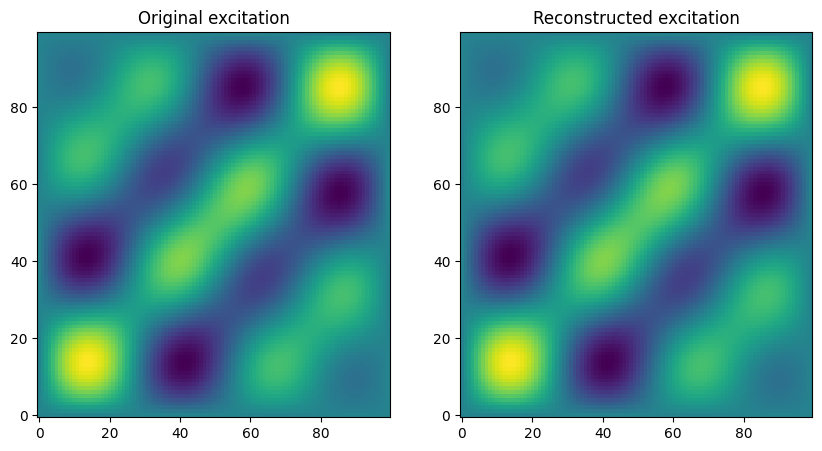

In [ ]:

length_x = 1.08
length_y = 0.8
n_max_modes_x = 25
n_max_modes_y = 25
n_gridpoints_x = 100
n_gridpoints_y = 100

x = np.linspace(0, length_x, n_gridpoints_x)
y = np.linspace(0, length_y, n_gridpoints_y)

wnx, wny = plate_wavenumbers(
    n_max_modes_x,
    n_max_modes_y,
    length_x,
    length_y,
)
K = plate_eigenfunctions(wnx, wny, x, y)

g = 0.5 * K[2, 2] + 0.5 * K[3, 3]

bar_g = forward_STL_2d(K, g, x, y, use_simpson=True)
g_reconstructed = inverse_STL_2d(K, bar_g, length_x, length_y)

assert np.allclose(g, g_reconstructed, atol=1e-2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(g, origin="lower", aspect="auto")
ax[0].set_title("Original excitation")
ax[1].imshow(g_reconstructed, origin="lower", aspect="auto")
ax[1].set_title("Reconstructed excitation")

In [ ]:
# | export

def forward_STL_drumhead(
    K: np.ndarray,  # (n_modes_r, n_modes_theta, n_gridpoints_r, n_gridpoints_theta)
    u: np.ndarray,  # (n_gridpoints_x, n_gridpoints_y, n_samples) or (n_gridpoints_x, n_gridpoints_y)
    r: np.ndarray,  # radial grid
    theta: np.ndarray,  # angular grid
    use_simpson: bool = False,
) -> np.ndarray:
    """
    Compute the forward STL transform. The integration is done using the trapezoidal rule or Simpson's rule.

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes_r, n_modes_theta, n_gridpoints_r, n_gridpoints_theta)
    u: np.ndarray
        The input signal. Shape (n_gridpoints_r, n_gridpoints_theta, n_samples) or (n_gridpoints_r, n_gridpoints_theta)
    dr: float
        The grid spacing of the sampled membrane.
    dtheta: float
        The grid spacing of the sampled membrane.

    Returns:
    --------
    np.ndarray
        The transformed signal. Shape (n_modes_r, n_modes_theta, n_samples) or (n_modes_r, n_modes_theta)
    """
    if u.ndim == 2:
        u = u[..., None]

    r_grid, _ = np.meshgrid(r, theta, indexing="ij")

    if use_simpson:

        max_n, max_m, _, _ = K.shape
        _, _, n_samples = u.shape

        transformed_signal = np.zeros((max_n, max_m, n_samples))

        for n in range(max_n):
            for m in range(max_m):
                for sample in range(n_samples):
                    integrand = (
                        u[..., sample] * K[n, m] * r_grid
                    )  # notice the r_grid (Jacobian determinant)
                    transformed_signal[n, m] = dblintegral(
                        integrand, x=r, y=theta, method="trapezoid"
                    )

    else:

        # integrand has shape (n_modes_r, n_modes_theta, n_gridpoints_r, n_gridpoints_theta)
        integrand = u[..., None].transpose(2, 3, 0, 1) * K * r_grid

        integral_y = trapezoid(integrand, x=theta, axis=-1)
        transformed_signal = trapezoid(integral_y, x=r, axis=-1)

    return (
        transformed_signal.squeeze()
        if transformed_signal.shape[-1] == 1
        else transformed_signal
    )


def inverse_STL_drumhead(
    K_inv: np.ndarray,  # (n_modes_x, n_modes_y, n_gridpoints_x, n_gridpoints_y)
    u_bar: np.ndarray,  # (n_modes_x, n_modes_y, n_samples) or (n_modes_x, n_modes_y)
) -> np.ndarray:
    """
    Compute the inverse STL transform using the formula of Rabenstein et al. (2000).

    Parameters:
    -----------

    K: np.ndarray
        The sampled eigenfunctions of the string. Shape (n_modes, n_gridpoints)
    u_bar: np.ndarray
        The transformed signal. Shape (n_modes, n_samples) or (n_modes,)
    length: float
        The length of the string.

    Returns:
    --------
    np.ndarray
        The reconstructed signal. Shape (n_gridpoints, n_samples) or (n_gridpoints,)
    """
    if u_bar.ndim == 2:
        u_bar = u_bar[
            ..., None
        ]  # Convert to (n_modes_x, n_modes_y, 1) if input is (n_modes_x, n_modes_y)

    reconstructed_signal = einsum("n m x y, n m s -> x y s", K_inv, u_bar)
    return (
        reconstructed_signal.squeeze() if u_bar.shape[-1] == 1 else reconstructed_signal
    )

-0.4320502477222054 0.43401550352665574
-0.4320519880367027 0.4340172517572766


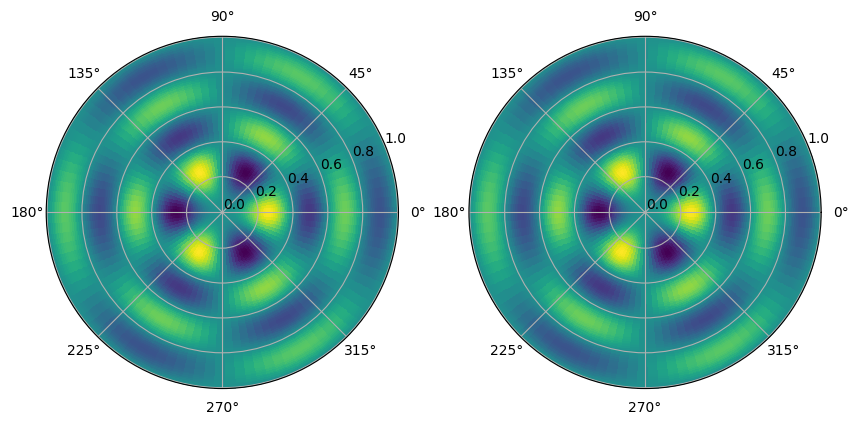

In [ ]:
# Example usage
n_max_modes = 10
m_max_modes = 10
radius = 1.0
n_gridpoints_r = 100
n_gridpoints_theta = 100

wavenumbers = drumhead_wavenumbers(n_max_modes, m_max_modes, radius)
eigenvalues = drumhead_eigenvalues(wavenumbers)
r = np.linspace(0, radius, n_gridpoints_r)
theta = np.linspace(0, 2 * np.pi, n_gridpoints_theta)
K_fwd, K_inv, K_N = drumhead_eigenfunctions(wavenumbers, r, theta)

assert np.allclose(
    K_fwd.shape, (n_max_modes, m_max_modes, n_gridpoints_r, n_gridpoints_theta)
)  # Should be (10, 10, 100, 100)
assert np.allclose(
    K_inv.shape, (n_max_modes, m_max_modes, n_gridpoints_r, n_gridpoints_theta)
)  # Should be (10, 10, 100, 100)

# Create an example g array to test the transforms
g = K_fwd[3, 3]

bar_g = forward_STL_drumhead(K_fwd, g, r, theta, use_simpson=False)
g_reconstructed = inverse_STL_drumhead(K_inv, bar_g)

# Verify if g can be reconstructed
assert np.allclose(g, g_reconstructed, atol=1e-2)
print(g.min(), g.max())
print(g_reconstructed.min(), g_reconstructed.max())

# Plot using pcolormesh
fig, ax = plt.subplots(
    1,
    2,
    subplot_kw={"projection": "polar"},
    figsize=(10, 5),
)
c = ax[0].pcolormesh(theta, r, g, shading="auto", cmap="viridis")
c = ax[1].pcolormesh(theta, r, g_reconstructed, shading="auto", cmap="viridis")

In [ ]:
# | export


def eigenvalues_from_pde(
    strpars: StringParameters,
    wavenumbers: np.ndarray,
) -> np.ndarray:
    """
    Compute the positive imaginary side of the eigenvalues of the continuous-time system from the PDE parameters.

    Parameters
    ----------
    d1 : float
        The linear damping coefficient.
    d3 : float
        The cubic damping coefficient.
    rho : float
        The density of the string.
    A : float
        The cross-sectional area of the string.
    E : float
        The Young's modulus of the string.
    I : float
        The second moment of area of the string.
    wavenumbers : np.ndarray
        The wavenumbers of the modes.

    Returns
    -------
    np.ndarray
        The eigenvalues of the continuous-time system.
    """

    sigma_mu = strpars.d1 + strpars.d3 * wavenumbers**2
    sigma_mu = sigma_mu / (2 * strpars.area_density)

    beta_mu = strpars.E * strpars.I * wavenumbers**4 + strpars.Ts0 * wavenumbers**2
    omega_mu_squared = (beta_mu / strpars.area_density) - sigma_mu**2

    omega_mu = np.sqrt(omega_mu_squared)  # imaginary-part frequency

    gt_eigenvalues = -sigma_mu + 1j * omega_mu  # continuous time eigenvalues
    return gt_eigenvalues

In [ ]:
from IPython.display import Audio

In [ ]:
n_max_modes = 50
sr = 44100
dt = 1 / sr
final_time = 1.0
n_samples = int(final_time / dt)
p_params = StringParameters()
mu = np.arange(1, n_max_modes + 1)
wn = np.pi * mu / p_params.length
eigvals = eigenvalues_from_pde(p_params, wn)

print(eigvals.imag.min() / (2 * np.pi))

eigvals_d = np.exp(eigvals * dt)

states = np.vander(eigvals_d, n_samples, increasing=True).real
display(Audio(states.sum(0), rate=sr))


247.0158068963442


In [ ]:
# | export


def eigenvalues_from_plate_pde(
    platepars: PlateParameters,
    wnx: np.ndarray,  # wavenumbers x (n_max_modes_x,)
    wny: np.ndarray,  # wavenumbers y (n_max_modes_y,)
) -> np.ndarray:
    """
    Compute the positive imaginary side of the eigenvalues of the continuous-time system from the PDE parameters of the rectangular plate. From 5.96 of Digital Sound Synthesis using the FTM, and Eq. 8 of TENSION MODULATED NONLINEAR 2D MODELS FOR DIGITAL SOUND SYNTHESIS WITH THE FUNCTIONAL TRANSFORMATION METHOD.

    Parameters
    ----------
    d1 : float
        The frequency independent damping coefficient.
    d3 : float
        The frequency dependent damping coefficient.
    rho : float
        The density of the string.
    A : float
        The cross-sectional area of the string.
    E : float
        The Young's modulus of the string.
    I : float
        The second moment of area of the string.
    wavenumbers : np.ndarray
        The wavenumbers of the modes.

    Returns
    -------
    np.ndarray
        The eigenvalues of the continuous-time system.
    """

    # The term that goes with the fourth spatial derivative
    # S = platepars.E * platepars.h**3 / (12 * (1 - platepars.nu**2))
    S = platepars.E * platepars.I / (1 - platepars.nu)

    Lambda_squared = plate_eigenvalues(wnx, wny, squared=True)
    Lambda = plate_eigenvalues(wnx, wny)

    sigma_mu = platepars.d0 + platepars.d2 * Lambda  # real-part decay
    sigma_mu = sigma_mu / (2 * platepars.surface_density)

    beta_mu = platepars.Tm * Lambda + S * Lambda_squared
    omega_mu_squared = beta_mu / platepars.surface_density - sigma_mu**2

    omega_mu = np.sqrt(omega_mu_squared)  # imaginary-part frequency

    gt_eigenvalues = -sigma_mu + 1j * omega_mu  # continuous time eigenvalues
    return gt_eigenvalues

In [ ]:
n_max_modes_x = 20
n_max_modes_y = 20
sr = 44100
dt = 1 / sr
final_time = 6.0
n_samples = int(final_time / dt)

p_params = PlateParameters()
wnx, wny = plate_wavenumbers(n_max_modes_x, n_max_modes_y, p_params.l1, p_params.l2)
eigvals = eigenvalues_from_plate_pde(p_params, wnx, wny).reshape(-1)

print(eigvals.imag.min() / (2 * np.pi))
eigvals_d = np.exp(eigvals * dt)

states = np.vander(eigvals_d, n_samples, increasing=True).real

display(Audio(states.sum(0), rate=sr))

10.456826975580865


In [ ]:
# | export


def eigenvalues_from_drumhead_pde(
    drumhead_pars: CircularDrumHeadParameters,
    Lambda_nm: np.ndarray,  # (n_max_modes_r, m_max_modes_theta)
) -> np.ndarray:
    """
    Compute the positive imaginary side of the eigenvalues of the continuous-time system from the PDE parameters of the rectangular plate. From 5.96 of Digital Sound Synthesis using the FTM, and Eq. 8 of TENSION MODULATED NONLINEAR 2D MODELS FOR DIGITAL SOUND SYNTHESIS WITH THE FUNCTIONAL TRANSFORMATION METHOD.

    Parameters
    ----------
    d1 : float
        The frequency independent damping coefficient.
    d3 : float
        The frequency dependent damping coefficient.
    rho : float
        The density of the string.
    A : float
        The cross-sectional area of the string.
    E : float
        The Young's modulus of the string.
    I : float
        The second moment of area of the string.
    wavenumbers : np.ndarray
        The wavenumbers of the modes.

    Returns
    -------
    np.ndarray
        The eigenvalues of the continuous-time system.
    """

    # The term that goes with the fourth spatial derivative
    D = drumhead_pars.E * drumhead_pars.h**3 / (12 * (1 - drumhead_pars.nu**2))

    sigma_mu = drumhead_pars.d0 + drumhead_pars.d2 * Lambda_nm  # real-part decay
    sigma_mu = sigma_mu / (2 * drumhead_pars.surface_density)

    omega_mu_squared = D * Lambda_nm**2 + drumhead_pars.Tm * Lambda_nm
    omega_mu_squared = omega_mu_squared / drumhead_pars.surface_density - sigma_mu**2

    omega_mu = np.sqrt(omega_mu_squared)  # imaginary-part frequency

    gt_eigenvalues = -sigma_mu + 1j * omega_mu  # continuous time eigenvalues
    return gt_eigenvalues

In [ ]:
n_max_modes_x = 20
n_max_modes_y = 20
sr = 44100
dt = 1 / sr
final_time = 2.0
n_samples = int(final_time / dt)
p_params = CircularDrumHeadParameters.avanzini()

v = drumhead_eigenvalues(drumhead_wavenumbers(n_max_modes_x, n_max_modes_y, p_params.r0))
eigvals = eigenvalues_from_drumhead_pde(p_params, v).reshape(-1)

# import matplotlib.pyplot as plt
print(eigvals.imag.min() / (2 * np.pi))
print(eigvals.imag.max() / (2 * np.pi))
# plt.plot(eigvals)

eigvals_d = np.exp(eigvals * dt)
states = np.vander(eigvals_d, n_samples, increasing=True).real

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(states[0])
display(Audio(states[0], rate=sr))

142.6549044721433
6141.459247890741


In [ ]:

# | export

def sample_parallel_tf(
    num: np.ndarray,  # (n_modes,)
    den: np.ndarray,  # (n_modes,)
    dt: float,
    method: str = "impulse",
):
    """
    Sample a parallel transfer function using the impulse invariant method.

    Parameters
    ----------
    num : np.ndarray
        The numerator of the transfer function.
    den : np.ndarray
        The denominator of the transfer function.

    Returns
    -------
    num_d : np.ndarray
        The numerator of the discrete-time transfer function.
    den_d : np.ndarray
        The denominator of the discrete-time transfer function.
    """

    def sample(n, d):
        b, a, _ = cont2discrete((n, d), dt, method=method)
        return b.flatten(), a.flatten()

    b, a = zip(*[sample(n, d) for n, d in zip(num, den)])

    return np.array(b), np.array(a)

In [ ]:
# | export

def tf_excitation_continuous(
    eigenvalues: np.ndarray,
    density: float,  # surface or area density
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the continuous excitation transfer function.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The surface density of a membrane (rho * h) or area density of a string (rho * A)
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    sigma_mu = -eigenvalues.real
    omega_mu = eigenvalues.imag

    a1 = sigma_mu * 2
    a2 = sigma_mu**2 + omega_mu**2

    ones = np.ones_like(sigma_mu)
    b = ones / density
    a = np.stack([ones, a1, a2], axis=-1)
    return b, a


def tf_excitation_discrete(
    eigenvalues: np.ndarray,
    density: float,  # surface or area density
    dt: float,  # time step
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the discrete-time excitation transfer function of a system.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The surface density of a membrane (rho * h) or area density of a string (rho * A)
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    b, a = tf_excitation_continuous(eigenvalues, density)

    # Discretize the system
    tf_d = sample_parallel_tf(b, a, dt)

    return tf_d

In [ ]:
# | export

def tf_initial_conditions_continuous(
    eigenvalues: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the continuos "initial-conditions" transfer function from the eigenvalues of the system.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The surface density of a membrane (rho * h) or area density of a string (rho * A)
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    sigma_mu = -eigenvalues.real
    omega_mu = eigenvalues.imag

    a1 = sigma_mu * 2
    a2 = sigma_mu**2 + omega_mu**2

    ones = np.ones_like(sigma_mu)
    b1 = a1

    b = np.stack([ones, b1], axis=-1)
    a = np.stack([ones, a1, a2], axis=-1)

    return (b, a)


def tf_initial_conditions_discrete(
    eigenvalues: np.ndarray,
    dt: float,  # time step
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the discrete-time initial conditions transfer function of a system.

    Parameters
    ----------
    eigenvalues : np.ndarray
        The eigenvalues of the system.
    density: float
        The surface density of a membrane (rho * h) or area density of a string (rho * A)
    dt : float
        The time step size.

    Returns
    -------
    np.ndarray
        The numerator of the discrete-time transfer function.
    np.ndarray
        The denominator of the discrete-time transfer function
    """
    b, a = tf_initial_conditions_continuous(eigenvalues)

    # Discretize the system
    tf_d = sample_parallel_tf(b, a, dt)

    return tf_d

In [ ]:
# | test

b, a = tf_excitation_discrete(eigvals, p_params.surface_density, dt)
b_ic, a_ic = tf_initial_conditions_discrete(eigvals, dt)

# manual discretization
eigenvalues_d = np.exp(eigvals * dt)

# for the excitation tf
b1 = (
    np.exp(eigvals.real * dt)
    * np.sin(eigvals.imag * dt)
    / eigvals.imag
    / p_params.surface_density
)

# for the initial conditions tf
b1_ic = (
    np.exp(eigvals.real * dt)
    * (
        np.sin(eigvals.imag * dt) / eigvals.imag * -eigvals.real
        - np.cos(eigvals.imag * dt)
    )
)

a1 = -2 * np.exp(eigvals.real * dt) * np.cos(eigvals.imag * dt)
a2 = np.exp(2 * eigvals.real * dt)
b_manual = np.stack([np.zeros_like(b1), b1, np.zeros_like(b1)], axis=-1) * dt
a_manual = np.stack([np.ones_like(a1), a1, a2], axis=-1)

b_ic_manual = np.stack([np.ones_like(b1_ic), b1_ic], axis=-1) * dt

print(b[0])
print(b_manual[0])
assert np.allclose(b[:, 1], b_manual[:, 1])
assert np.allclose(a, a_manual)
assert np.allclose(b_ic[:, :2], b_ic_manual[:, :2])

[0.00000000e+00 1.90416682e-09 1.11022302e-16]
[0.00000000e+00 1.90416703e-09 0.00000000e+00]
